Please note this lab requires gym package <= 0.20. You can directly use pip install gym==0.2 if you haven't installed gym package before.

---

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [13]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import seaborn as sns
import pandas as pd

---
## 1. Policy Evaluation

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in Sutton's Reinforcement Learning book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [14]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

Type:        GridworldEnv
String form: <GridworldEnv instance>
File:        ~/Coding Projects/Berkeley Projects/Data-Science-with-VC-apps/LAB7and8/gridworld.py
Docstring:  
Grid World environment from Sutton's Reinforcement Learning book chapter 4.
You are an agent on an MxN grid and your goal is to reach the terminal
state at the top left or the bottom right corner.

For example, a 4x4 grid looks as follows:

T  o  o  o
o  x  o  o
o  o  o  o
o  o  o  T

x is your position and T are the two terminal states.

You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
Actions going off the edge leave you in your current state.
You receive a reward of -1 at each step until you reach a terminal state.


In [15]:
# To have a quick look into the code
??env

Type:        GridworldEnv
String form: <GridworldEnv instance>
File:        ~/Coding Projects/Berkeley Projects/Data-Science-with-VC-apps/LAB7and8/gridworld.py
Source:     
class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.

    For example, a 4x4 grid looks as follows:

    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T

    x is your position and T are the two terminal states.

    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](http://www.incompleteideas.net/book/RLbook2020.pdf) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [16]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P[1]

{0: [(1.0, 1, -1.0, False)],
 1: [(1.0, 2, -1.0, False)],
 2: [(1.0, 5, -1.0, False)],
 3: [(1.0, 0, -1.0, True)]}

In [17]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        v = np.zeros(env.nS)
        for s in range(env.nS):
            for action, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][action]:
#                     print(prob, next_state, reward, done)
                    v[s]+= action_prob*prob*(reward+discount_factor*V[next_state])
        
            delta = max(delta, abs(v[s]-V[s]))
            V[s] = v[s]
        if delta < theta:
            break
        
    return np.array(V)


In [18]:
#Your code here: Please initialize a random policy that would move to each direction with 1/4 probability
random_policy = np.ones([env.nS, env.nA]) / env.nA
#End of your code

In [19]:
random_policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [20]:
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

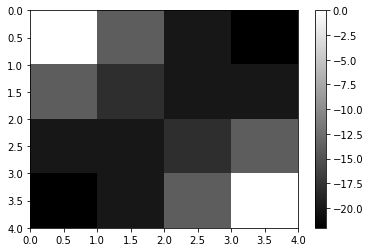

In [21]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

---
## 2. Policy Iteration
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [22]:
# calculate for each action in A, for state s
def backup(V, s, env, policy, discount_factor=1.0):
    V_a = np.zeros(env.nA)
    
    #NOTE: no expectation over actions, calculate for all actions in your Action space
        
    for action in range(env.nA) :
        policy[s,action] = 0
        for prob, next_state, reward, done in env.P[s][action]:
             V_a[action]+= prob*(reward+discount_factor*V[next_state])
    
    return V_a, policy

In [23]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
#     print(np.arange(env.nA), policy[0])
#     np.random.choice(int(np.arange(env.nA)), policy[0])
    
    while True:
        
        V = policy_eval(policy, env, discount_factor)
        
        # YOUR CODE HERE
        policy_stable = True
        for s in range(env.nS):
            
            #get an old action             
            #old_action = np.random.choice(np.arange(env.nA), 1, list(policy[s]))
            old_action = np.argmax(policy[s])
            
            #calculate V(s) for each s: by backup diagram (one-step lookahead)
            action_values, policy = backup(V, s, env, policy)
            #print(policy)
            
            a_max_i = np.argwhere(action_values == np.amax(action_values))
            policy[s,a_max_i.flatten()] = 1
            policy[s,:] = policy[s,:]/np.sum([policy[s,:]])
             
            if np.argmax(policy[s,:])!=old_action:
                policy_stable = False
       
        
        if policy_stable:
            break 
    
    return policy, V

Policy Probability Distribution:
[[0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.5  0.5 ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.5  0.5  0.  ]
 [0.   0.   1.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



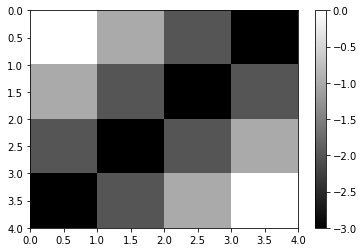

In [24]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

---
## 3. Value Iteration
Now implement the value iteration algorithm.

In [25]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    # Implement!
    while True:
        delta = 0
        for s in range(env.nS):
            
            # Get action_values and best_val
            # YOUR CODE HERE
            action_values,_ = backup(V, s, env, policy)
            best_val = np.amax(action_values)
            # End of code
            
            delta = max(delta, abs(best_val-V[s]))
            V[s] = best_val
            
        if delta < theta:
            break
            
    #calculate optimal policy
    for s in range(env.nS):
        action_values, policy = backup(V, s, env, policy)
        
        a_max_i = np.argwhere(action_values == np.amax(action_values))
        policy[s,a_max_i.flatten()] = 1
        policy[s,:] = policy[s,:]/np.sum([policy[s,:]])
      
    return policy, V

In [26]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.5  0.5 ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.5  0.5  0.  ]
 [0.   0.   1.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

**YOUR ANSWER HERE**

Keypoints:

1 **Policy iteration** includes: **policy evaluation** + **policy improvement**, and the two are repeated iteratively until policy converges.

2 **Value iteration** includes: finding optimal **value function** + **one policy extraction**. There is no repeat of the two because once the value function is optimal, then the policy out of it should also be optimal (i.e. converged).

3 Finding optimal **value function** can also be seen as a combination of **policy improvement** (due to max) and truncated policy evaluation (the reassignment of v_(s) after just one sweep of all states regardless of convergence). Precisely, in policy iteration, for each of its iteration involves policy evaluation which itself be a protracted iterative computation requiring multiple sweeps through the state set. Whereas in value iteration the policy evaluation is stopped after one sweep. Its update rule combines the policy improvement and truncated policy evaluation steps. In general, the entire class of truncated policy iteration algorithms can be thought of as sequences of sweeps, some of which use policy evaluation updates and some of which use value iteration updates.

The algorithms for policy evaluation and finding optimal value function are highly similar except for a max operation. If we talk  in terms of backups both methods have to perform complete backups with only difference of expectation and max in policy iteration and value iteration respectively. Value iteration will be computationally more efficient because it doesn't have multiple steps of policy evaluation which has very little effect after first few steps on the corresponding greedy policy.




## 4. Monte Carlo Prediction 
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

DP uses Bellman equations with transition probabilities and rewards, while MC estimates values by sampling returns. DP is model-based and MC is model-free. DP is more efficient with a model, but MC is more robust with non-Markovian processes. Which one to use depends on resources and problem properties. DP good with model and Markov, MC good with no model or non-Markov. DP+MC can be used, like in actor-critic.


For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [27]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [28]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

Init signature: gym.Env(*args, **kwargs)
Docstring:     
The main OpenAI Gym class. It encapsulates an environment with
arbitrary behind-the-scenes dynamics. An environment can be
partially or fully observed.

The main API methods that users of this class need to know are:

    step
    reset
    render
    close
    configure
    seed

When implementing an environment, override the following methods
in your subclass:

    _step
    _reset
    _render
    _close
    _configure
    _seed

And set the following attributes:

    action_space: The Space object corresponding to valid actions
    observation_space: The Space object corresponding to valid observations
    reward_range: A tuple corresponding to the min and max possible rewards

The methods are accessed publicly as "step", "reset", etc.. The
non-underscored versions are wrapper methods to which we may add
functionality over time.
File:           ~/opt/anaconda3/lib/python3.7/site-packages/gym/core.py
Type:           type
Subcla

In [29]:
# We can also look at the documentation/implementation of a method
?env.step

Signature: env.step(action)
Docstring:
Run one timestep of the environment's dynamics. When end of
episode is reached, you are responsible for calling `reset()`
to reset this environment's state.

Accepts an action and returns a tuple (observation, reward, done, info).

Args:
    action (object): an action provided by the environment

Returns:
    observation (object): agent's observation of the current environment
    reward (float) : amount of reward returned after previous action
    done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
    info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
File:      ~/Coding Projects/Berkeley Projects/Data-Science-with-VC-apps/LAB7and8/blackjack.py
Type:      method


In [30]:
??BlackjackEnv

Init signature: BlackjackEnv(*args, **kwargs)
Source:        
class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning 

In [31]:
?env.action_space.n


Type:        int
String form: 2
Docstring:  
int([x]) -> integer
int(x, base=10) -> integer

Convert a number or string to an integer, or return 0 if no arguments
are given.  If x is a number, return x.__int__().  For floating point
numbers, this truncates towards zero.

If x is not a number or if base is given, then x must be a string,
bytes, or bytearray instance representing an integer literal in the
given base.  The literal can be preceded by '+' or '-' and be surrounded
by whitespace.  The base defaults to 10.  Valid bases are 0 and 2-36.
Base 0 means to interpret the base from the string as an integer literal.
>>> int('0b100', base=0)
4


A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [34]:
# s = env.reset()
# print(s)
def simple_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    current_sum, dealer_sum, usable = observation
    # YOUR CODE HERE
#       stick(return 0)
    if current_sum>20: 
        return 0
    else:
        return 1

#       hit(return 1)
    # End OF YOUR CODE

In [35]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(14, 8, False)
((21, 8, False), 0, False, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [36]:
def generate_episodes(env, policy):
    episode = []
    state = env.reset()
    
    while True:
         
        #hit or stick             
        a = policy(state)
        next_state, reward, flag, _ = env.step(a)
        episode.append((state, a, reward))
        if flag:
            break
        state = next_state
        
    return episode

In [37]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    # YOUR CODE HERE
    for i in tqdm(range(num_episodes)):
        #episode = [((16, 9, True), 1, 0), ((16, 9, False), 1, 0), ((17, 9, False), 1, -1)]

        episode = generate_episodes(env, policy)
       
        episode_state = [epi[0] for epi in episode]
        
        for indx, (state, _ , _) in enumerate(episode):
            
            #get first occurence
            idx = episode_state.index(state)
            
            #check if it is the first occurence
            if idx < indx:
                continue
            
            #calculate return from this index
            G = sum([reward*discount_factor**i for i, (_, _, reward) in enumerate(episode[idx:])]) 
            returns_sum[state]  += G
            returns_count[state]+= 1.0
            V[state] = returns_sum[state]/returns_count[state]
          
            
            
    
    return V

In [38]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

100%|██████████| 1000/1000 [00:00<00:00, 6140.44it/s]

defaultdict(<class 'float'>, {(13, 4, False): -1.0, (14, 10, False): -0.7741935483870968, (17, 10, False): -0.7209302325581395, (15, 5, False): -0.6666666666666666, (12, 5, False): -1.0, (18, 10, True): -0.5, (18, 10, False): -0.6585365853658537, (21, 10, False): 0.8536585365853658, (15, 10, False): -0.7857142857142857, (20, 10, False): -0.8529411764705882, (16, 10, False): -0.8717948717948718, (15, 8, False): -0.7647058823529411, (18, 8, False): -0.8461538461538461, (14, 2, False): -0.7142857142857143, (15, 2, False): -0.8333333333333334, (20, 1, False): -0.7647058823529411, (21, 1, False): 0.6363636363636364, (16, 9, False): -0.7142857142857143, (19, 9, False): -0.9, (20, 9, False): -0.3333333333333333, (16, 5, False): -1.0, (20, 5, False): -1.0, (12, 4, False): -1.0, (16, 4, False): -0.8, (18, 4, False): -0.7777777777777778, (19, 4, False): -1.0, (20, 4, False): -1.0, (19, 6, False): -1.0, (15, 6, False): -0.8181818181818182, (20, 3, False): -0.8947368421052632, (17, 2, False): -0.5

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [39]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:55<00:00, 8996.68it/s] 

CPU times: user 53.1 s, sys: 1.29 s, total: 54.4 s
Wall time: 56.9 s


In [40]:
# YOUR CODE HERE
def surface_plots(fig, X, Y, Z, idx=1, title = None):

    ax = fig.add_subplot(1,2,idx, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    

def plot_function(V, title=None):
    
    #player     
    min_x = min([key[0] for key in V.keys()])
    max_x = max([key[0] for key in V.keys()])
   
    #dealer
    min_y = min([key[1] for key in V.keys()])
    max_y = max([key[1] for key in V.keys()])
    
    X = np.arange(min_x, max_x+1)
    Y = np.arange(min_y, max_y+1)
    
    X, Y = np.meshgrid(X, Y)
    
    #get values for usable ace and Non usable ace
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace   = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    fig = plt.figure(figsize=(15, 5))
       
    surface_plots(fig,X, Y, Z_ace,  1,title +"_"+'usable ace')
    surface_plots(fig,X, Y, Z_noace, 2,title +"_"+'No usable ace')
    plt.tight_layout()
    plt.show()
    

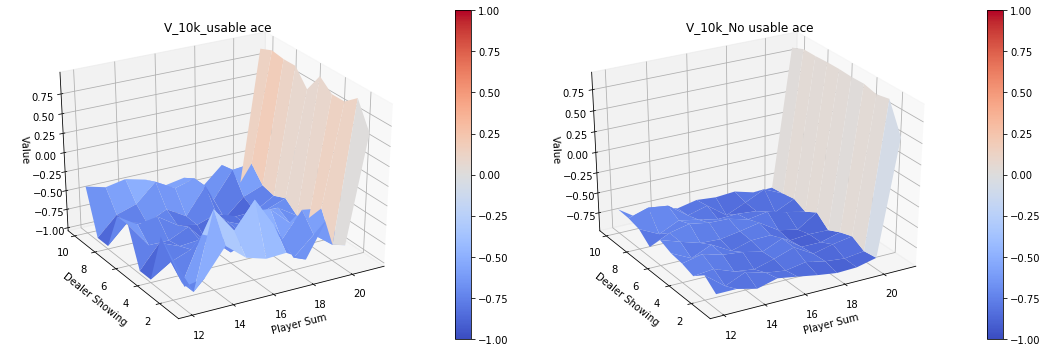

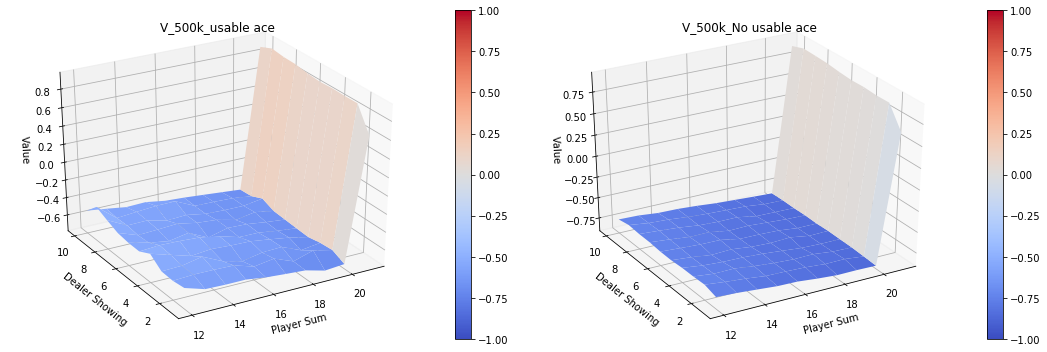

In [41]:
plot_function(V_10k, "V_10k")
plot_function(V_500k, "V_500k")

## 5. Monte Carlo control with $\epsilon$-greedy policy
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy.

In [42]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        
        #make epsilon soft policy i.e policy_fn(a|s)>0
        A = np.ones(nA, dtype = float)*1/nA
        
        if np.random.random() < epsilon:
            return np.random.choice(np.arange(nA), p=A)
        
        else:
            return np.argmax(Q[observation])
        
    return policy_fn

def generate_episodes(env, policy):
    episode = []
    state = env.reset()
    
    while True:
         
        #hit or stick
        action = policy(state)
        next_state, reward, flag, _ = env.step(action)
        episode.append((state, action, reward))
        
        if flag:
            break
        state = next_state
        
    return episode

In [43]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i in tqdm(range(num_episodes)):
        #episode = [((16, 9, True), 1, 0), ((16, 9, False), 1, 0), ((17, 9, False), 1, -1)]
                         
        episode = generate_episodes(env, policy)
        
        episode_state_action = [(epi[0],epi[1]) for epi in episode]
        
        for indx, (state, action , _) in enumerate(episode):
            
            #get first occurence
            idx = episode_state_action.index((state,action))
            
            #check if it is the first occurence
            if idx < indx:
                continue
            #calculate return from this index
            G = sum([reward*discount_factor**i for i, (_, _, reward) in enumerate(episode[idx:])]) 
            
            returns_sum[state][action]  += G
            returns_count[state][action]+= 1.0
            Q[state][action] = returns_sum[state][action]/returns_count[state][action]

        
    
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 10000/10000 [00:01<00:00, 6509.00it/s]


In [44]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [01:10<00:00, 7083.89it/s]

CPU times: user 1min 7s, sys: 1.56 s, total: 1min 8s
Wall time: 1min 10s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

In [45]:
def plot_policy(Q, policy, title=None):
    
    #player     
    max_x = max([key[0] for key in Q.keys()])
   
    #dealer
    max_y = max([key[1] for key in Q.keys()])
    
    X = np.arange(12, max_x+1)
    Y = np.arange(1, max_y+1)
    
    a_usable_ace, a_non_usable_ace = np.ones((len(X),len(Y))),np.ones((len(X),len(Y)))
    
    #get values for usable ace and Non usable ace
    for idx_x,x in enumerate(X):
        for idy_y,y in enumerate(Y):
            a_usable_ace[idx_x,idy_y] = policy((x,y, True))
            a_non_usable_ace[idx_x,idy_y] = policy((x,y, False))

    images = [a_usable_ace, a_non_usable_ace]

    titles = ['Greedy policy with usable Ace_'+title,
              'Greedy policy without usable Ace_'+title,
              ]
    
    _, axes = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for image, title, axis in zip(images, titles, axes):
        fig = sns.heatmap(np.flipud(image), cmap="binary_r", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=10)
        fig.set_xlabel('dealer showing', fontsize=10)
        fig.set_title(title, fontsize=10)

    plt.show()    
    
    

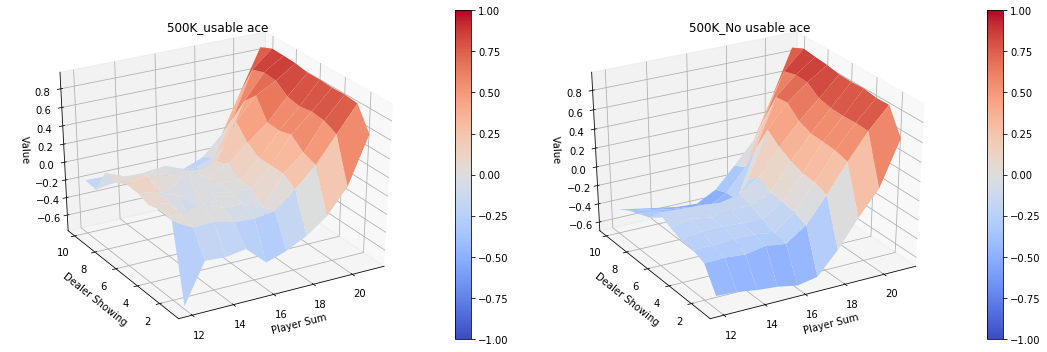

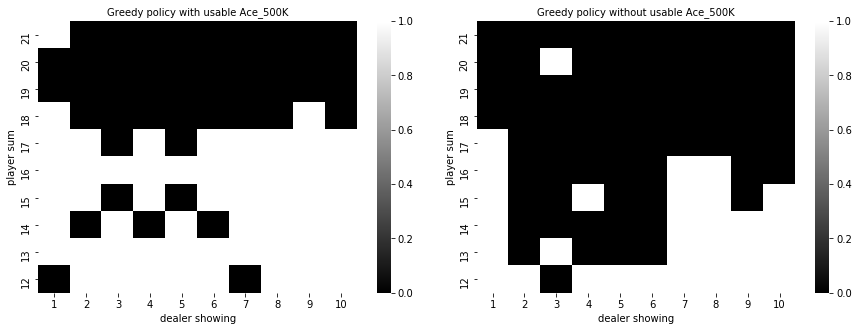

In [46]:
# YOUR CODE HERE
# V(s) = max over all a(q(s,a))
V = defaultdict(float)
for s, a in Q.items():
    V[s] = np.amax(a)
plot_function(V, "500K")
plot_policy(Q, policy, "500K")

## 6. Temporal Difference (TD) learning 
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

One advantage of MC is that it doesn't require knowledge of the transition probabilities, making it more applicable to real-world problems with unknown dynamics. However, MC can suffer from high variance and the need for many samples to obtain an accurate estimate.

In situations where we have a lot of data, like in online learning or when data is generated from an ongoing process, TD learning can be a good choice. For example, if we want to train a self-driving car to make decisions in real-time using sensor data, TD learning can quickly update the value estimates after each experience, allowing the car to learn on the fly.

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [47]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

In [48]:
??env

Type:            WindyGridworldEnv
String form:     <WindyGridworldEnv instance>
File:            ~/Coding Projects/Berkeley Projects/Data-Science-with-VC-apps/LAB7and8/windy_gridworld.py
Source:         
class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape 

100%|██████████| 1000/1000 [00:00<00:00, 1176.00it/s]


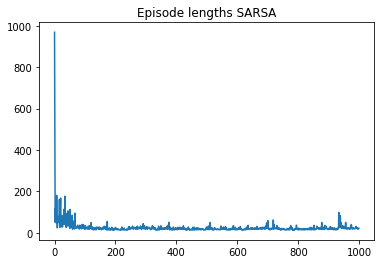

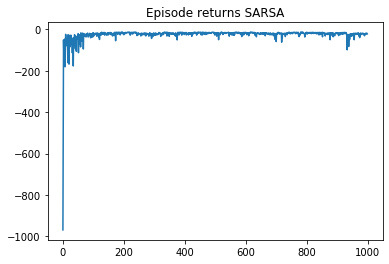

In [49]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        #intialize S
        state = env.reset()
        action = policy(state)

        while True:
            
            S_dash, reward, flag, _ = env.step(action)
            
            a_dash = policy(S_dash)

            Q[state][action] += alpha*(reward + discount_factor*Q[S_dash][a_dash]-Q[state][action]) 
            
            if flag:
                break
            
            state = S_dash
            action = a_dash
            i+=1
            R+=reward
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

Since we might not be interested in falling off the cliff all the time, we can find another person to do this 'exploration' for us (in the name of science). Still, we would like to learn ourselfs from this persons policy, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|██████████| 1000/1000 [00:00<00:00, 1403.35it/s]


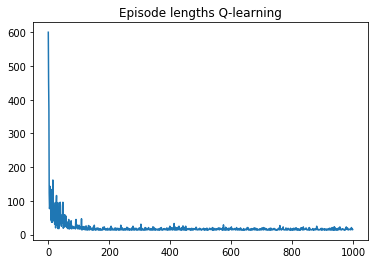

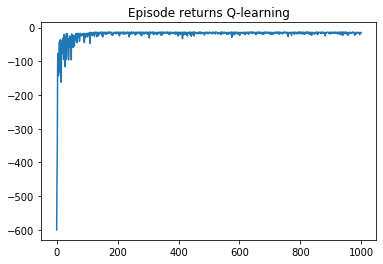

In [50]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        #intialize S
        state = env.reset()
        
        while True:
            
            action = policy(state)

            S_dash, reward, flag, _ = env.step(action)
             
            a_dash = np.argmax(Q[S_dash])  
            Q[state][action] += alpha*(reward + discount_factor*Q[S_dash][a_dash]-Q[state][action]) 
            
            if flag:
                break
            
            state = S_dash
            i+=1
            R+=reward
        
        stats.append((i, R))
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead). Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

In [51]:
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1897.06it/s]


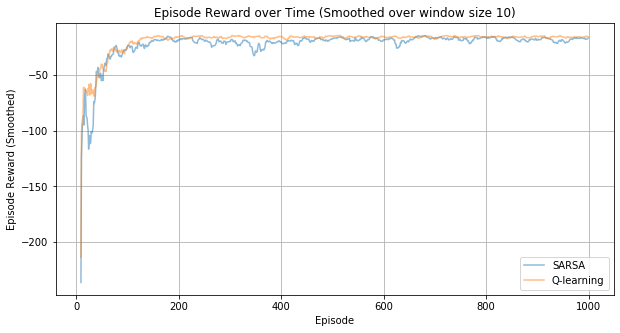

In [52]:
# YOUR CODE HERE

fig = plt.figure(figsize=(10,5))

rewards_smoothed = pd.Series(episode_returns_sarsa).rolling(10, min_periods=10).mean()
plt.plot(rewards_smoothed,label="SARSA", alpha=0.5)

rewards_smoothed_Q = pd.Series(episode_returns_q_learning).rolling(10, min_periods=10).mean()
plt.plot(rewards_smoothed_Q, label="Q-learning", alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time (Smoothed over window size {})".format(10))
plt.legend()
plt.grid(True)
plt.show()

**YOUR ANSWER HERE**


In case of windy Gridworld, both SARSA and Q-Learning algorithm performs equally well. In terms of rewards, Q-Learning gives slightly better rewards as compared to SARSA. This is because in Q_Learning we always consider the action that gives us maximum future rewards over all action where is in SARSA we use $\epsilon$-greedy policy. This is different from the Example 6.6 because in Cliff Walking, a large negative rewards awaits for falling into the cliff. SARSA would consider the safe path away from the cliff and would gain overall better rewards. Whereas Q_Learning will take the optimal part with occasionally taking large negative rewards for falling into the cliff. This results in SARSA obtaining better rewards than Q-Learning.

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

**YOUR ANSWER HERE**

The Q-learning will perform better than SARSA because the learned Q values are maximum over all possible action. For SARSA, the policy evaluated by taking greedy action in the Q value function may not be the optimal path with maximum reward because of following a $\epsilon$-greedy policy during the learning phase. In some cases, SARSA obtain the same optimal solution as Q-learning but only by chance after training.

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

**Answer:** Here, three experiments are performed with SARSA and Q-learning learned separately everytime. Only one run of evaluation is enough to evaluate a policy by choosing greedy action.

In [53]:
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1815.57it/s]


In [54]:
# YOUR CODE HERE
def eval_policy(Q,state):
    R = 0
    s = [state]
    a_ = []

    end_episode = False
    while not end_episode:
        a = np.argmax(Q[state])
        next_state, reward, end_episode, _ = env.step(a)

        state = next_state
        R += reward
        s.append(state)
        a_.append(a)

    print("Reward:",R,"\n States in the grid world:",s,"\n action taken in each state:",a_)
        
    return R

print("\n------------------------------------------\nSARSA evaluation:\n--------------------------------------------")
state = env.reset()
rewards_SARSA = eval_policy(Q_sarsa,state)
print("\n------------------------------------------\nQ-learning evaluation:\n----------------------------------------------")
state = env.reset()
rewards_q_learning = eval_policy(Q_q_learning, state)


------------------------------------------
SARSA evaluation:
--------------------------------------------
Reward: -16.0 
 States in the grid world: [30, 31, 32, 33, 24, 15, 5, 6, 7, 8, 9, 19, 29, 39, 49, 48, 37] 
 action taken in each state: [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3]

------------------------------------------
Q-learning evaluation:
----------------------------------------------
Reward: -15.0 
 States in the grid world: [30, 31, 32, 33, 24, 15, 6, 7, 8, 9, 19, 29, 39, 49, 48, 37] 
 action taken in each state: [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3]


In the above evaluation, it is evident that SARSA will not give better reward, or the best path as compared to Q-learning even though both reaches the same goal state.

In [55]:
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1805.33it/s]


In [56]:
print("\n------------------------------------------\nSARSA evaluation:\n--------------------------------------------")
state = env.reset()
rewards_SARSA = eval_policy(Q_sarsa,state)
print("\n------------------------------------------\nQ-learning evaluation:\n----------------------------------------------")
state = env.reset()
rewards_q_learning = eval_policy(Q_q_learning, state)


------------------------------------------
SARSA evaluation:
--------------------------------------------


This is one such case where SARSA performs equally well as Q-Learning after training.

In [ ]:
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 100000)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 100000)

100%|██████████| 100000/100000 [00:40<00:00, 2486.87it/s]


In [ ]:
print("\n------------------------------------------\nSARSA evaluation:\n--------------------------------------------")
state = env.reset()
rewards_SARSA = eval_policy(Q_sarsa,state)
print("\n------------------------------------------\nQ-learning evaluation:\n----------------------------------------------")
state = env.reset()
rewards_q_learning = eval_policy(Q_q_learning, state)


------------------------------------------
SARSA evaluation:
--------------------------------------------
Reward: -16.0 
 States in the grid world: [30, 20, 21, 22, 23, 14, 5, 6, 7, 8, 9, 19, 29, 39, 49, 48, 37] 
 action taken in each state: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3]

------------------------------------------
Q-learning evaluation:
----------------------------------------------
Reward: -15.0 
 States in the grid world: [30, 31, 32, 33, 24, 15, 6, 7, 8, 9, 19, 29, 39, 49, 48, 37] 
 action taken in each state: [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3]


This experiments shows that training for longer iteration doesn't really helps in obtaining optimal policy. The Q-learning still outputs the same optimal reward better than SARSA.